# Tutorial on Interrupted Time Series Analysis with Prophet. (Use <= Python 3.8)

This tutorial pertains to training and evaluating an interrupted time series model in python using the open-ource Prophet libarary by Facebook Inc. (https://facebook.github.io/prophet/)

We will walk through 6 main steps:

1) Installing and/loading loading required libraries<br>
2) Generating dummy time series data for the analysis<br>
3) Getting forecasts<br>
4) Tuning hyperparameters<br> 
5) Get forecasts using tuned hyperparameters<br>
6) Evaluation model performance using cross validation

## 1. Install and/or Import Required Libraries


In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install scipy
!pip install pystan==2.19.1.1
!pip install prophet --no-cache

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from random import sample, seed
from scipy.stats import wilcoxon
from fbprophet import Prophet
from datetime import datetime, timedelta

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

## 2. Create Dummy Data
This step involves creating and preparing dummy data for demonstrating interrupted time series analysis. We will create fictitious emergency department visits data in a single region from January 2017 through December 2020

#### a) create the date column, listing months starting Jan 2017 through Dec 2020

In [4]:
ds = pd.date_range('2017-01-01','2020-12-01', 
              freq='MS').strftime("%Y-%m").tolist()
ds = pd.DatetimeIndex(ds)
ds

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq=None)

#### b) create dummy data for monthly counts of emergency department visits

In [5]:
y = [9731, 11678, 12005, 12345, 13472, 12929, 12456, 11689, 10783, 10342, 10657, 10937, 
     11476, 12198, 12897, 13672, 14229, 13854, 12679, 12183, 11842, 11685, 11997, 12490, 
     11699, 13712, 13999, 14206, 14971, 14528, 14156, 13588, 12681, 12441, 12758, 12897, 
     13592, 14372, 13154, 11786, 12249, 11867, 11598, 11183, 11892, 11487, 11134, 12269]


#### c) create the dataframe

In [6]:
df = pd.DataFrame(zip(ds,y), columns =['ds','y'])
df.head(5)

,ds,y
0,2017-01-01,9731
1,2017-02-01,11678
2,2017-03-01,12005
3,2017-04-01,12345
4,2017-05-01,13472


#### d) plot the data

In [7]:
def plot_ts(data, title):
    sns.set(rc={'figure.figsize':(8,6)})
    sns.set_style("white")
    mpl.rcParams['font.size'] = 8.0
    mpl.rcParams["font.weight"] = "bold"
    mpl.rcParams["axes.labelweight"] = "bold"

    df = data.copy()
    df = df.set_index(df['ds'])
    plt.plot(df['y'], color ='black', linewidth=0.5)
    plt.title(title,fontsize = 18, fontweight='bold')
    plt.xticks(rotation=90, fontsize =16, fontweight='bold')
    plt.yticks(fontsize =16, fontweight='bold') 
    plt.ylabel('new visits', fontsize =16, fontweight='bold')
    plt.show()
    plt.close()

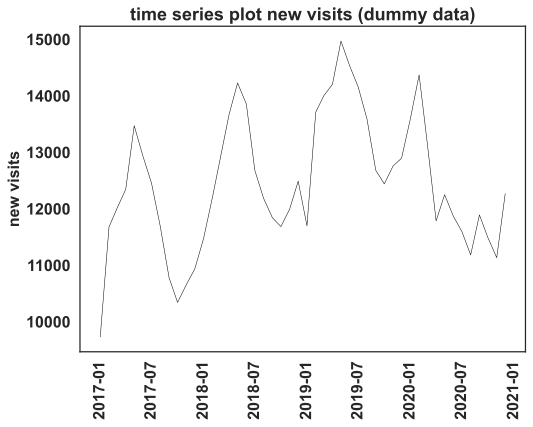

In [8]:
plot_ts(df, 'time series plot new visits (dummy data)')

## 3. Get forecasts 

We can now train an ITS models using the dummy data. We train the model using data up to Feb 01, 2020, and then use the model to predict the outcome for the remaining months in our data. We then compare the trends in the actual and predicted outcomes

#### a) Specify prediction period

In [9]:
prediction_start_date='2020-03-01'
prediction_end_date='2020-12-01'

#### b) Get forecasts

In [10]:
def get_forecasts(location, outcome, data, seasonality_mode='additive', changepoint_prior_scale=0.05, seasonality_prior_scale=10.0, prediction_start_date='2020-03-01', prediction_end_date='2020-06-01'):
    
    df = data.copy()  

    prediction_start_date = datetime.strptime(prediction_start_date, '%Y-%m-%d')
    
    prediction_end_date = datetime.strptime(prediction_end_date, '%Y-%m-%d')
    
    df = df[df['ds']<=prediction_end_date] 

    df_training = df[df['ds']<prediction_start_date] 

    df_test = df[df['ds']>=prediction_start_date]
    
    m = Prophet(interval_width=.95, 
            growth ='linear',
            yearly_seasonality=False, 
            weekly_seasonality = False, 
            daily_seasonality = False,
            seasonality_mode = seasonality_mode,
            changepoint_prior_scale = changepoint_prior_scale,
            seasonality_prior_scale = seasonality_prior_scale,
            ).add_seasonality(
                name='yearly',
                period = 365,
                fourier_order = 5
            )

    m.fit(df_training)

    prediction_periods = df_test.shape[0]

    future = pd.DataFrame(df['ds'], columns = ['ds'])
    
    forecast = m.predict(future)

    forecast['y'] = [i for i in df['y']]
    
    forecast['yhat-y'] =forecast['yhat']- forecast['y']
    
    return forecast[['ds','y','yhat','yhat-y','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']].copy()


In [11]:

forecast_results = get_forecasts(location = 'Dummy Location',
                                                  outcome = 'New Visits',
                                                  data = df, 
                                                  prediction_start_date=prediction_start_date,
                                                  prediction_end_date = prediction_end_date)
forecast_results.tail(10)

,ds,y,yhat,yhat-y,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
38,2020-03-01,13154,14948.259349,1794.259349,14506.615645,15418.202711,14227.771555,14227.770504,14227.772648
39,2020-04-01,11786,15374.503815,3588.503815,14918.860134,15814.961539,14310.885080,14310.881895,14310.888545
40,2020-05-01,12249,16210.066485,3961.066485,15753.121546,16668.600100,14391.317523,14391.311419,14391.324175
41,2020-06-01,11867,15678.188917,3811.188917,15280.079207,16100.609157,14474.431048,14474.421730,14474.441180
42,2020-07-01,11598,15058.491194,3460.491194,14600.626625,15490.171195,14554.863492,14554.851327,14554.877523
43,2020-08-01,11183,14397.723519,3214.723519,13987.841726,14827.566075,14637.977017,14637.960564,14637.995534
44,2020-09-01,11892,13730.194093,1838.194093,13292.861308,14192.936554,14721.090542,14721.070336,14721.112937
45,2020-10-01,11487,13423.573272,1936.573272,12960.847463,13878.624305,14801.522985,14801.497843,14801.549672
46,2020-11-01,11134,13802.308448,2668.308448,13362.047935,14248.757266,14884.636510,14884.606413,14884.668174
47,2020-12-01,12269,14037.126972,1768.126972,13614.771760,14464.721499,14965.068954,14965.034456,14965.106556


#### c) Plot forecasts

In [12]:
def plot_its(location, outcome, forecast, prediction_start_date, prediction_end_date):
    
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set_style("white")
    mpl.rcParams['font.size'] = 8.0
    mpl.rcParams["font.weight"] = "bold"
    mpl.rcParams["axes.labelweight"] = "bold"

    prediction_start_date = datetime.strptime(prediction_start_date, '%Y-%m-%d')
    prediction_end_date = datetime.strptime(prediction_end_date, '%Y-%m-%d')
    
    plt.axvspan(xmin = prediction_start_date , xmax=prediction_end_date, color='grey', alpha=0.2, lw=0)
    
    plt.scatter(forecast['ds'],forecast['y'], facecolors='none', edgecolors='black', s =20, label = 'observed values')
    plt.xlim([forecast['ds'].min(),prediction_end_date])
    
    plt.plot(forecast['ds'],forecast['yhat'], color = '#33adff', label ='predicted values')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#33adff', alpha=0.25)

    plt.plot(forecast['ds'],forecast['trend'], color = 'red', linestyle ="--", label ='predicted trend')
    plt.fill_between(forecast['ds'], forecast['trend_lower'], forecast['trend_upper'], color='red', alpha=0.2)
    
    plt.xticks(rotation=90, fontsize =18, fontweight='bold')
    plt.yticks(fontsize =18, fontweight='bold') 
    
    plt.xlabel('') 
    plt.ylabel('count', fontsize =18, fontweight='bold')
        
    title = '{} in {}'.format(outcome,location)
    plt.title(title,fontsize = 20, fontweight='bold')
    plt.legend(loc='upper left',fontsize=12)
    plt.show()
    plt.close()

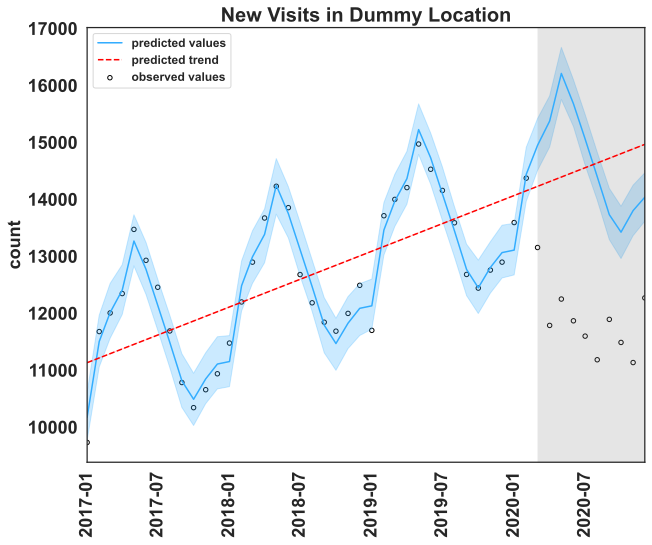

In [13]:
plot_its(location = 'Dummy Location',        
         outcome = 'New Visits',
         forecast=forecast_results,
         prediction_start_date=prediction_start_date,
         prediction_end_date = prediction_end_date)

In [14]:
def plot_cumulative(location, outcome, forecast, prediction_start_date, prediction_end_date):
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set_style("white")
    mpl.rcParams['font.size'] = 8.0
    mpl.rcParams["font.weight"] = "bold"
    mpl.rcParams["axes.labelweight"] = "bold"
    
    prediction_start_date = datetime.strptime(prediction_start_date, '%Y-%m-%d')
    prediction_end_date = datetime.strptime(prediction_end_date, '%Y-%m-%d')
    plt.xlim([forecast['ds'].min(),prediction_end_date])
    plt.axvspan(xmin = prediction_start_date , xmax=prediction_end_date, color='grey', alpha=0.2, lw=0)
    plt.plot(forecast['ds'],forecast['y'].cumsum(), color = 'orange', label ='actual values')    
    plt.plot(forecast['ds'],forecast['yhat'].cumsum(), color = '#33adff', label ='predicted values')
    
    plt.xticks(rotation=90, fontsize =18, fontweight='bold')
    plt.yticks(fontsize =18, fontweight='bold') 
    
    plt.xlabel('') 
    plt.ylabel('Cumulative counts', fontsize =18, fontweight='bold')
        
    title = 'Cumulative {} in {}'.format(outcome, location)
    plt.title(title,fontsize = 20, fontweight='bold')
    plt.legend(loc='upper left',fontsize=12)
    plt.show()
    plt.close()
    

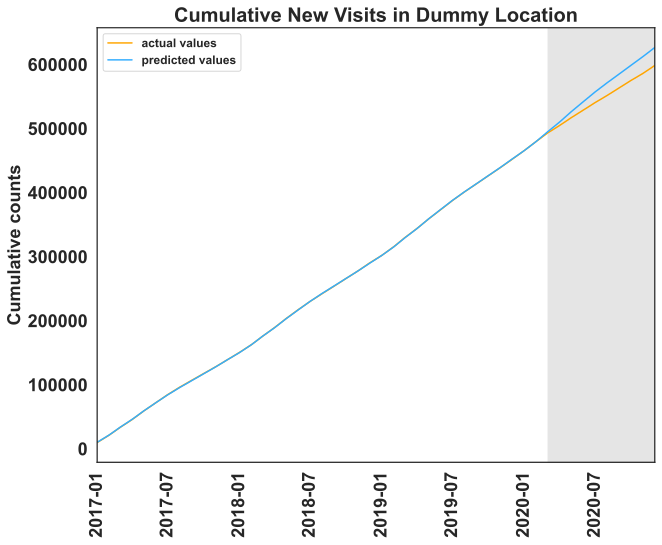

In [15]:
plot_cumulative(location = 'Dummy Location',        
                outcome = 'New Visits',
                forecast=forecast_results,
                prediction_start_date =  prediction_start_date,
                prediction_end_date = prediction_end_date)

#### b) Get metrics

In [16]:
def get_metrics(location, outcome, forecast, prediction_start_date, prediction_end_date):
    
    prediction_start_date = datetime.strptime(prediction_start_date, '%Y-%m-%d')
    prediction_end_date = datetime.strptime(prediction_end_date, '%Y-%m-%d')

    df_before = forecast[forecast['ds']<prediction_start_date]

    df_after = forecast[(forecast['ds']>=prediction_start_date) & (forecast['ds']<=prediction_end_date)]

    metrics = dict()
    metrics['location'] = location
    metrics['outcome'] = outcome
    
    metrics['mape_before'] = round(np.mean(((df_before['y'] - df_before['yhat'])/df_before['y']).abs()),2)
    metrics['mape_after'] = round(np.mean(((df_after['y'] - df_after['yhat'])/df_after['y']).abs()),2)
    
    metrics['actual_mean_before'] = int(round(df_before['y'].mean(),0))
    metrics['predicted_mean_before'] = int(round(df_before['yhat'].mean(),0))
    metrics['actual_mean_after'] = int(round(df_after['y'].mean(),0))
    metrics['predicted_mean_after'] = int(round(df_after['yhat'].mean(),0))
    
    metrics['actual_median_before'] = int(round(df_before['y'].median(),0))
    metrics['predicted_median_before'] = int(round(df_before['yhat'].median(),0))
    metrics['actual_median_after'] = int(round(df_after['y'].median(),0))
    metrics['predicted_median_after'] = int(round(df_after['yhat'].median(),0))
    
    metrics['wilcoxon_before'] = (wilcoxon(df_before['yhat-y']))
    metrics['wilcoxon_after'] = (wilcoxon(df_after['yhat-y'] ))
    
    #plot
    sns.set(rc={'figure.figsize':(8,6)})
    sns.set_style("white")
    mpl.rcParams['font.size'] = 8.0
    mpl.rcParams["font.weight"] = "bold"
    mpl.rcParams["axes.labelweight"] = "bold"
    sns.kdeplot(df_before['yhat-y'], shade=True, label ='Before')
    sns.kdeplot(df_after['yhat-y'], shade=True, label ='After')
    plt.title('Distribution of yhat-y before and after interruption', fontsize = 16, fontweight='bold')
    plt.show()
    plt.close()
    
    return metrics

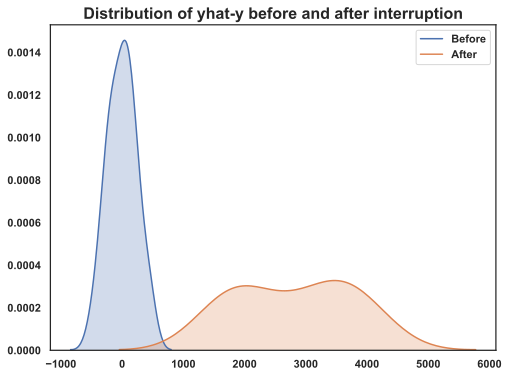

{'location': 'Dummy Location',
 'outcome': 'New Visits',
 'mape_before': 0.02,
 'mape_after': 0.24,
 'actual_mean_before': 12627,
 'predicted_mean_before': 12627,
 'actual_mean_after': 11862,
 'predicted_mean_after': 14666,
 'actual_median_before': 12584,
 'predicted_median_before': 12625,
 'actual_median_after': 11826,
 'predicted_median_after': 14673,
 'wilcoxon_before': WilcoxonResult(statistic=366.0, pvalue=0.9479667982801983),
 'wilcoxon_after': WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)}

In [17]:
itl_metrics = get_metrics(location = 'Dummy Location',    
                          outcome = 'New Visits',
                          forecast=forecast_results,
                          prediction_start_date =  prediction_start_date,
                          prediction_end_date = prediction_end_date)
itl_metrics 

## 4. Tune hyperparameters 

In [18]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools

In [19]:
cutoff_start='2018-02-01'
cutoff_end='2019-10-01'

In [20]:
def tune_hyperparameters(location, outcome, data, cutoff_start='2019-02-01', cutoff_end='2019-10-01'):
    
    df = data.copy() 
    
    cutoff_start = datetime.strptime(cutoff_start, '%Y-%m-%d')
    cutoff_end = datetime.strptime(cutoff_end, '%Y-%m-%d')
    cutoffs = pd.date_range(start=cutoff_start, end=cutoff_end, freq='MS')    
    
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative'],
    }
    
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(interval_width=.95, 
                    growth ='linear',
                    yearly_seasonality=False, 
                    weekly_seasonality = False, 
                    daily_seasonality = False,
                    **params
                   ).add_seasonality(
                        name='yearly',
                        period = 365,
                        fourier_order = 5
                   )
        m.fit(df)  
        df_cv = cross_validation(model=m, horizon='90 days', cutoffs=cutoffs, parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    tuning_results = tuning_results.sort_values('rmse')
    best_params = all_params[np.argmin(rmses)]
    
    return tuning_results, best_params
    

In [21]:
tuning_results, best_params = tune_hyperparameters(location = 'Dummy Location', 
                                                   outcome = 'New Visits',
                                                   data=df, 
                                                   cutoff_start = cutoff_start, 
                                                   cutoff_end = cutoff_end)
best_params

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849ca71760>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849ca82880>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849caad370>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849ca7ceb0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849b9e1be0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849ca71070>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849cacd2e0>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f849caa5f70>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPool

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'additive'}

In [22]:
tuning_results.head(5)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
2,0.001,0.1,additive,343.680722
10,0.010,0.1,additive,345.784566
14,0.010,10.0,additive,346.847755
12,0.010,1.0,additive,347.773543
6,0.001,10.0,additive,348.868408


## 5. Get forecasts using tuned hyperparameters

In [23]:
forecast_results_tuned= get_forecasts(location = 'Dummy Location', 
                                      outcome = 'New Visits',
                                      data=df, 
                                      seasonality_mode = best_params['seasonality_mode'],
                                      changepoint_prior_scale = best_params['changepoint_prior_scale'],
                                      seasonality_prior_scale = best_params['seasonality_prior_scale'],
                                      prediction_start_date=prediction_start_date,
                                      prediction_end_date = prediction_end_date)
forecast_results_tuned.head(10)

,ds,y,yhat,yhat-y,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2017-01-01,9731,10177.457763,446.457763,9752.282810,10617.102077,11139.204164,11139.204164,11139.204164
1,2017-02-01,11678,11510.549671,-167.450329,11082.295507,11963.209476,11221.291046,11221.291046,11221.291046
2,2017-03-01,12005,12012.386124,7.386124,11599.876162,12443.156985,11295.434035,11295.434035,11295.434035
3,2017-04-01,12345,12405.564086,60.564086,11967.822906,12859.391418,11377.520917,11377.520917,11377.520917
4,2017-05-01,13472,13271.565924,-200.434076,12844.730870,13707.409043,11456.959835,11456.959835,11456.959835
5,2017-06-01,12929,12771.798920,-157.201080,12330.832297,13194.343744,11539.046717,11539.046717,11539.046717
6,2017-07-01,12456,12142.732172,-313.267828,11696.211985,12563.980215,11618.485634,11618.485634,11618.485634
7,2017-08-01,11689,11488.043056,-200.956944,11067.793784,11917.367552,11700.572516,11700.572516,11700.572516
8,2017-09-01,10783,10812.906407,29.906407,10383.214723,11280.378733,11782.659398,11782.659398,11782.659398
9,2017-10-01,10342,10489.213434,147.213434,10082.034795,10956.149703,11862.098316,11862.098316,11862.098316


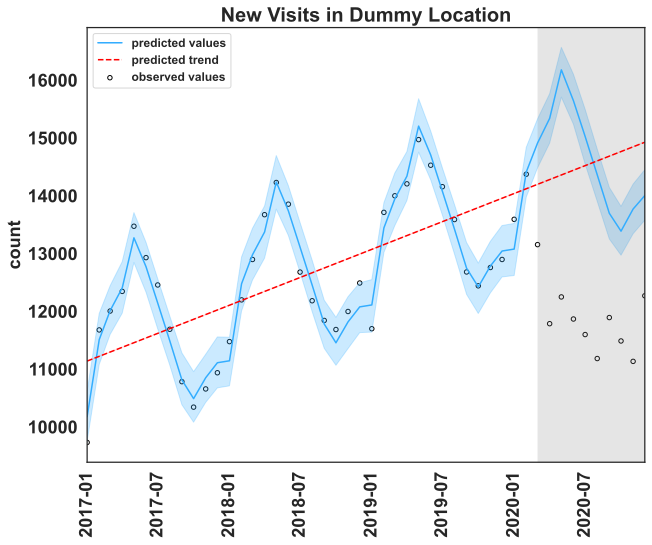

In [24]:
plot_its(location = 'Dummy Location', 
         outcome = 'New Visits',
         forecast=forecast_results_tuned,
         prediction_start_date=prediction_start_date,
         prediction_end_date = prediction_end_date)

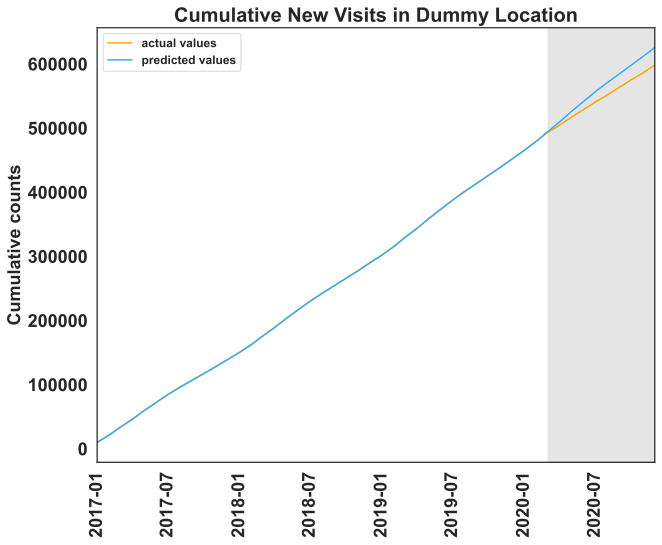

In [25]:
plot_cumulative(location = 'Dummy Location', 
                outcome = 'New Visits',
                forecast = forecast_results_tuned,
                prediction_start_date =  prediction_start_date,
                prediction_end_date = prediction_end_date)

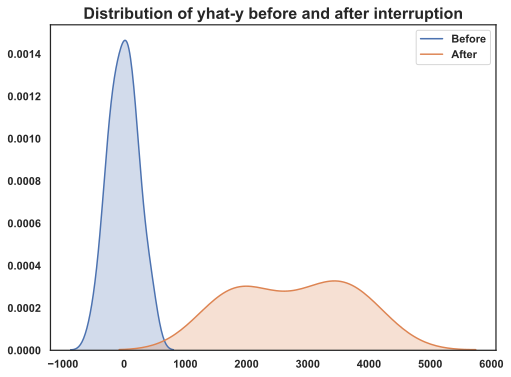

{'location': 'Dummy Location',
 'outcome': 'New Visits',
 'mape_before': 0.02,
 'mape_after': 0.23,
 'actual_mean_before': 12627,
 'predicted_mean_before': 12616,
 'actual_mean_after': 11862,
 'predicted_mean_after': 14632,
 'actual_median_before': 12584,
 'predicted_median_before': 12611,
 'actual_median_after': 11826,
 'predicted_median_after': 14637,
 'wilcoxon_before': WilcoxonResult(statistic=350.0, pvalue=0.7662400379626741),
 'wilcoxon_after': WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)}

In [26]:
itl_metrics_tuned = get_metrics(location = 'Dummy Location', 
                                outcome = 'New Visits',
                                forecast = forecast_results_tuned,
                                prediction_start_date =  prediction_start_date,
                                prediction_end_date = prediction_end_date)
itl_metrics_tuned

In [27]:
def plot_density(location, outcome, metrics):
    sns.set(rc={'figure.figsize':(8,6)})
    sns.set_style("white")
    mpl.rcParams['font.size'] = 8.0
    mpl.rcParams["font.weight"] = "bold"
    mpl.rcParams["axes.labelweight"] = "bold"
    
    ax1.fill_between(x=df['date_reported'],y1=  df['new_cases_per_100k_ewm7'], interpolate=True, color="#33adff", alpha =.25)

    
    plt.axvspan(xmin = prediction_start_date , xmax=prediction_end_date, color='grey', alpha=0.2, lw=0)
    
    plt.scatter(forecast['ds'],forecast['y'], facecolors='none', edgecolors='black', s =20, label = 'observed values')
    plt.xlim([forecast['ds'].min(),prediction_end_date])
    
    plt.plot(forecast['ds'],forecast['yhat'], color = '#33adff', label ='predicted values')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#33adff', alpha=0.25)

    plt.plot(forecast['ds'],forecast['trend'], color = 'red', linestyle ="--", label ='predicted trend')
    plt.fill_between(forecast['ds'], forecast['trend_lower'], forecast['trend_upper'], color='red', alpha=0.2)
    
    plt.xticks(rotation=90, fontsize =18, fontweight='bold')
    plt.yticks(fontsize =18, fontweight='bold') 
    
    plt.xlabel('') 
    plt.ylabel('count', fontsize =18, fontweight='bold')
        
    title = '{} in {}'.format(outcome,location)
    plt.title(title,fontsize = 20, fontweight='bold')
    plt.legend(loc='upper left',fontsize=12)
    plt.show()
    plt.close()
    

## 6. Performance Evaluation using Model Cross Validation

In [28]:
def cross_validate(location, outcome, data, seasonality_mode='additive', changepoint_prior_scale=0.05, seasonality_prior_scale=10.0, cutoff_start='2019-02-01', cutoff_end='2019-10-01'):
    
    df = data.copy()  

    m = Prophet(interval_width=.95, 
            growth ='linear',
            yearly_seasonality=False, 
            weekly_seasonality = False, 
            daily_seasonality = False,
            seasonality_mode = seasonality_mode,
            changepoint_prior_scale = changepoint_prior_scale,
            seasonality_prior_scale = seasonality_prior_scale,
            ).add_seasonality(
                name='yearly',
                period = 365,
                fourier_order = 5
            )
    
    m.fit(df)
    
    cutoff_start = datetime.strptime(cutoff_start, '%Y-%m-%d')
    cutoff_end = datetime.strptime(cutoff_end, '%Y-%m-%d')
    cutoffs = pd.date_range(start=cutoff_start, end=cutoff_end, freq='MS')
    
    df_cv = cross_validation(model=m, horizon='90 days', cutoffs=cutoffs)
    
    return df_cv
    

In [29]:
df_cv = cross_validate(location = 'Dummy Location', 
                       outcome = 'New Visits',
                       data = df,
                       seasonality_mode = best_params['seasonality_mode'],
                       changepoint_prior_scale = best_params['changepoint_prior_scale'],
                       seasonality_prior_scale = best_params['seasonality_prior_scale'],
                       cutoff_start = cutoff_start, 
                       cutoff_end = cutoff_end)
df_cv

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-01,13072.543857,12752.748770,13403.025107,12897,2018-02-01
1,2018-04-01,13487.155414,13162.650578,13811.659764,13672,2018-02-01
2,2018-05-01,14539.532728,14201.155240,14869.757364,14229,2018-02-01
3,2018-04-01,13399.552456,13099.461430,13708.914820,13672,2018-03-01
4,2018-05-01,14472.716628,14150.786302,14802.169438,14229,2018-03-01
5,2018-05-01,14565.775544,14263.172087,14892.526488,14229,2018-04-01
6,2018-06-01,14056.533688,13747.570636,14370.514530,13854,2018-04-01
7,2018-06-01,13940.797021,13637.829137,14288.751091,13854,2018-05-01
8,2018-07-01,13450.191633,13139.977020,13798.738662,12679,2018-05-01
9,2018-07-01,13478.230333,13140.135344,13811.765884,12679,2018-06-01


In [30]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,30 days,201934.059287,449.370737,385.375284,0.029745,0.025351,0.428571
1,31 days,87755.736789,296.235948,267.847157,0.020796,0.018653,0.916667
2,59 days,46786.740821,216.302429,197.892222,0.014571,0.014922,0.979167
3,61 days,162709.695916,403.372899,343.752777,0.026908,0.019936,0.600000
4,62 days,64654.206941,254.271915,193.290310,0.014825,0.012095,0.900000
5,89 days,84324.441085,290.386710,254.358612,0.017878,0.021584,0.750000
6,90 days,74990.075520,273.843159,224.125142,0.015390,0.016652,0.750000


In [31]:
def plot_cv_metric(location, outcome, df_cv):
    sns.set(rc={'figure.figsize':(10,8)})
    sns.set_style("white")
    mpl.rcParams['font.size'] = 8.0
    mpl.rcParams["font.weight"] = "bold"
    mpl.rcParams["axes.labelweight"] = "bold"
    
    plot_cross_validation_metric(df_cv, metric='mape')
    plt.xticks(fontsize =18, fontweight='bold')
    plt.yticks(fontsize =18, fontweight='bold') 
    plt.xlabel('Horizon',fontsize =18, fontweight='bold')
    plt.ylabel('MAPE', fontsize =18, fontweight='bold')
        
    title = 'MAPE for {} in {}'.format(outcome, location)
    plt.title(title,fontsize = 20, fontweight='bold')
    plt.show()
    plt.close()    

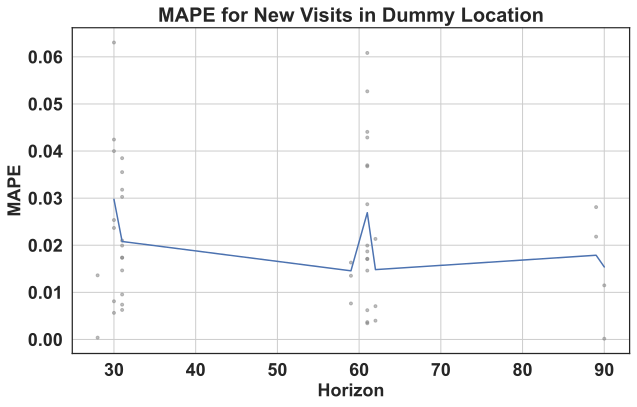

In [32]:
plot_cv_metric(location = 'Dummy Location', 
               outcome = 'New Visits',
               df_cv = df_cv)